In [2]:
import gym
import random
import pickle
from collections import deque
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils import mean, argmax
import time
import datetime

In [ ]:
import ORF_py_cython as ORF

In [ ]:
class ORF_DQN: 
    
    def __init__(self, n_state, n_action, replay_size, ORFparams):
        self.n_action = n_action
        self.a_model = {} # to build RF for each action
        self.a_params = {a: ORFparams for a in range(n_action)}
        self.isFit = False
        self.maxTrees = ORFparams['maxTrees']
    
    def predict(self, s):            
        # s: (4,) array (for cartpole)
        # preds = []
        # for a in range(self.n_action):
        #     preds.append(self.a_model[a].predict(s))
        
        preds = [self.a_model[a].predict(s) for a in range(self.n_action)]
        print(preds)
        return preds

    def gen_epsilon_greedy_policy(self, epsilon, n_action):
        
        def policy_function(state):
            # state: (4,) array
            ran = "_"
            q_values =[0.0, 0.0]
            if random.uniform(0,1) < epsilon:
                ran = "Random"
                return([random.randint(0, n_action - 1), ran, q_values])
            else:
                if self.isFit == True:
                    ran = "Model"
                    q_values = self.predict(state) # (1,2) array
                    # print(q_values)
                else: 
                    ran = "Random_notFit"
                    return([random.randint(0, n_action - 1), ran, q_values])
                    # print("passed random.randint")
            return([argmax(q_values), ran, q_values])# int
        
        return policy_function

    def replay(self, memory, replay_size, gamma, episode):

        if len(memory) == replay_size: # Build initial Forests
            
            for a in range(self.n_action):
                self.a_params[a]['xrng'] = ORF.dataRange([v[0] for v in memory if v[1] == a])
                self.a_model[a] = ORF.ORF(self.a_params[a]) # Fit initial RFs for each action            

        if len(memory) >= replay_size: # When the memory size exceeds the replay_size, start updating the RFs            
            
            replay_data = random.sample(memory, replay_size) # replay_data consists of [state, action, next_state, reward, is_done]
            for state, action, next_state, reward, is_done in replay_data:
                
                q_values = self.predict(state) # (, n_actions)
                q_values[action] = reward + gamma * max(self.predict(next_state)) if is_done == False else reward
                
                # Update the RF for the action taken
                xrng = ORF.dataRange([v[0] for v in replay_data if v[1] == action])
                self.a_model[action].update(state, q_values[action], xrng)    
            self.isFit = True
               
        if episode == 100: # expand the number of trees at episode 100            
            # expandForest(memory)
            for a in range(self.n_action):
                self.a_params[a]['xrng'] = ORF.dataRange([v[0] for v in memory if v[1] == a])
                lenFor = len(self.a_model[a].forest)
                for i in range(lenFor+1, self.maxTrees):
                    self.a_model[a].forest[i] = ORF.ORT(self.a_params[a]) # build new empty trees

def q_learning(env, estimator, n_episode, replay_size, gamma=1.0, epsilon=0.1, epsilon_decay=0.95):
    
    for episode in tqdm(range(n_episode)):
        policy = estimator.gen_epsilon_greedy_policy(epsilon, n_action)
        state = env.reset()
        is_done = False
        i = 0
        while not is_done:
            action, ran, pred = policy(state) # integer
            next_state, reward, is_done, _ = env.step(action)
            i += 1
            # print(action)
            # next_state: 4x1 array (for cartpole)
            # reward: integer
            # is_done: bool (True/False)

            total_reward_episode[episode] += reward
            
            # Modified rewards for mtcar depending on its location 
            # assign larger reward for being close to the right side

            modified_reward = next_state[0] + 0.5
            if next_state[0] >= 0.5: 
                modified_reward += 100 
            elif next_state[0] >= 0.25:
                modified_reward += 20
            elif next_state[0] >= 0.1:
                modified_reward += 10
            elif next_state[0] >= 0:
                modified_reward += 5

            ep[episode].append((i, state, ran, action))
            memory.append((state, action, next_state, modified_reward, is_done))
            
            if is_done:
                break
            estimator.replay(memory, replay_size, gamma, episode)
            state = next_state
        epsilon = max([epsilon * epsilon_decay, 0.01])
        # print(epsilon)


In [ ]:
# Initialization
env = gym.envs.make("MountainCar-v0")
n_state = env.observation_space.shape[0]
n_action = env.action_space.n

memory = deque(maxlen=100000)
n_episode = 50
replay_size = 32

ORFparams = {'minSamples': replay_size*4, 'minGain': 0.1, 'xrng': None, 'maxDepth': 50, 'numTrees': 5, 'maxTrees': 30} # numTrees -> 30 after 100 iters. 25 restarts

dqn = ORF_DQN(n_state, n_action, replay_size, ORFparams) 

total_reward_episode = [0] * n_episode

ep = {i: [] for i in range(n_episode)}

QLparams = {'gamma' : 1.0, 'epsilon' : 1.0, 'epsilon_decay' : 0.99}

In [ ]:
# Run alg

start = time.time()

q_learning(env, dqn, n_episode, replay_size, gamma=QLparams['gamma'], epsilon=QLparams['epsilon'], epsilon_decay=QLparams['epsilon_decay']) # runs the alg

end = time.time()

duration = int(end - start)

print("learning duration =", duration, " seconds")
print("mean reward = ", mean(total_reward_episode))
print("max reward = ", max(total_reward_episode))

In [ ]:
backup_file_name = "ORF_MountainCar_" + time.strftime("%y%m%d") + "_1"
img_file = backup_file_name + ".jpg"
plt.plot(total_reward_episode)
plt.title("(ORF) Total reward per episode")
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.hlines(195, xmin=0, xmax=n_episode, linestyles="dotted", colors="gray")
plt.show()
plt.savefig(fname = img_file)

In [ ]:
# About MountainCar
# Actions: discrete(3) 0:left, 1:no push, 2: push right
# Reward: -1 for each time step, until the goal position of 0.5 is reached.
# Starting state: Random position from -0.6 to 0.4 with no velocity
# Episode termination: ends when the car reaches 0.5 position, or if 200 iterations are reached.
# Solve requirement: get average reward of -110.0 over 100 consecutive trials.


In [3]:
with open("mtcar_extraModifiedRewards_3.p", "rb") as file:
    myEnv = pickle.load(file)

In [7]:
ep = myEnv['ep']
total_reward_episode = myEnv["tre"]


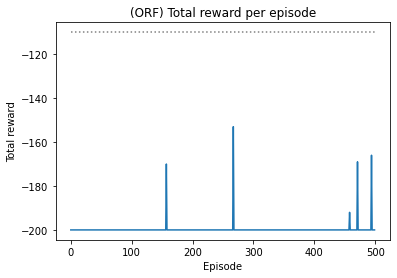

In [9]:
n_episode = 500
plt.plot(total_reward_episode)
plt.title("(ORF) Total reward per episode")
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.hlines(-110, xmin=0, xmax=n_episode, linestyles="dotted", colors="gray")
plt.show()

In [38]:
total_reward_episode.index(max(total_reward_episode))

267

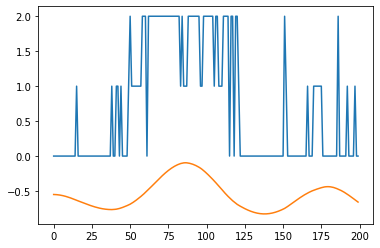

In [58]:
ep_num = 499
positions = list()
velocity = list()
actions  = list()
ran = list()
for i in ep[ep_num]:
    positions.append(i[1][0])
    velocity.append(i[1][1])
    actions.append(i[3])
    ran.append(i[2])
plt.plot(actions)
plt.plot(positions)